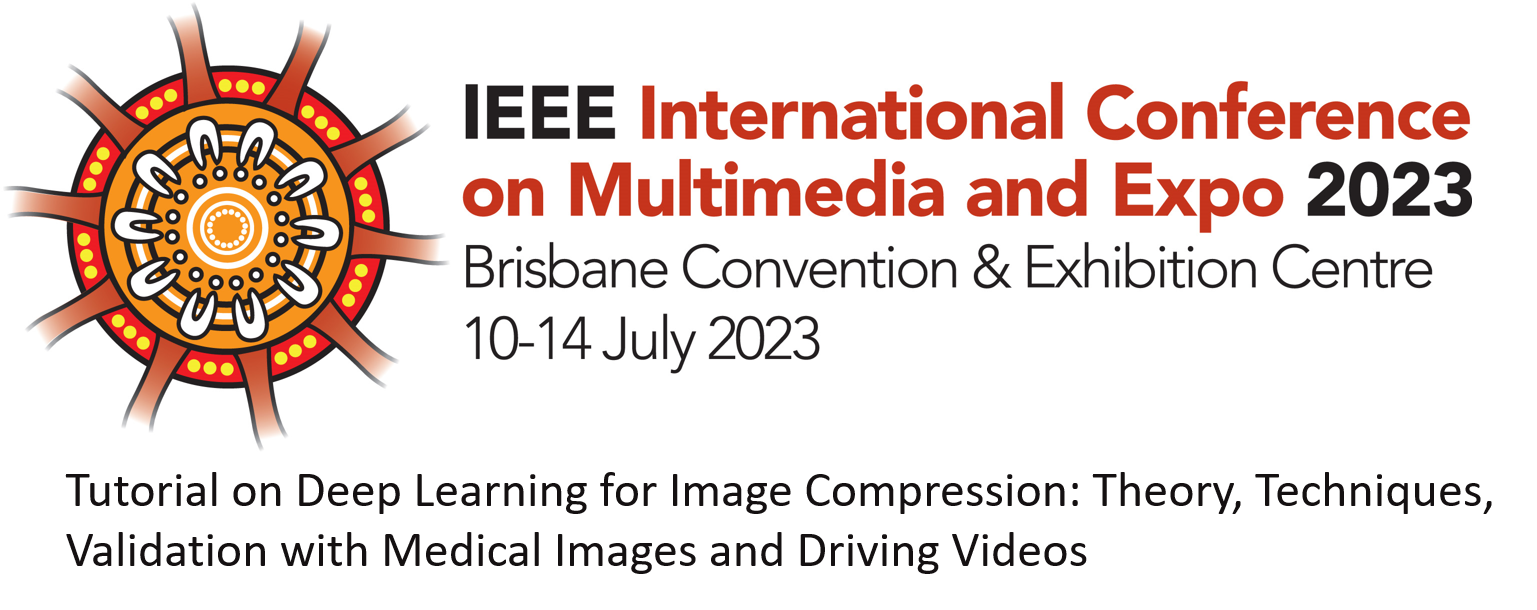

#Hands-on Session 2:

## Instructions to use

GPU for training, CPU for inference

In [16]:
!pip install wget
!pip install torchmetrics
!pip install tqdm

ERROR: Could not find a version that satisfies the requirement mathplotlib (from versions: none)
ERROR: No matching distribution found for mathplotlib


In [17]:
import torch
from torch import nn
from torch.utils import data
from PIL import Image
import os
import wget
import zipfile
import torchvision
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt

In [3]:
config = {
    "stage1": {
        "dest_path_data": "test_data/phase1.zip",
        "url_data": "http://kliv.iitkgp.ac.in/projects/miriad/sample_data/bmi34/phase1/phase1.zip",
        "url_model": "http://kliv.iitkgp.ac.in/projects/miriad/model_weights/bmi34/cbis_a1_b1.zip",
        "dest_path_model": "model_weights/cbis_a1_b1.zip"
    },
    "test_data": {
        "url": "http://kliv.iitkgp.ac.in/projects/miriad/sample_data/rbis_ddsm_sample.zip",
        "dest_path": "test_data/rbis_ddsm_sample.zip"
    }
}

## Download a sample training data


In [4]:

def download_and_extract(path, url, expath):
    wget.download(url, path)
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(expath)

def download_data(config):
    if not os.path.exists('test_data'):
        os.makedirs('test_data')
        data_url = config['stage1']['url_data']
        data_path = config['stage1']['dest_path_data']
        download_and_extract(path=data_path, url=data_url, expath='test_data/')

# Here test_data coressponds to sample/dummy data to test the code.


download_data(config)

In [5]:
model_config = {
    "train": {
        "train_data": "test_data/phase1/train/",
        "test_data": "test_data/phase1/test/",
        "batch_size": 10,
        "lr": 1e-8,
    },
}

In [6]:
class CustomDatasetPhase1(data.Dataset):

    def __init__(self, path_to_dataset, files256=None,files128=None,split=None,
                transform_images = None, transform_masks = None,
                images_path_rel = '.', masks_path_rel = '.',
                preserve_names = False):
        self.path_to_dataset = os.path.abspath(path_to_dataset)
        self.files256 = files256
        self.files128 = files128
        self.images_path_rel = images_path_rel # relative path to images
        self.masks_path_rel = masks_path_rel # relative path to masks (same as images)
        self.transform_images = transform_images # transforms
        self.preserve_names = preserve_names # not important, debugging stuff
        self.split = split
        self.test_files = os.listdir(self.path_to_dataset)

        # This is the list of all samples
        self.cropimages = os.listdir(os.path.join(self.path_to_dataset, self.images_path_rel))


    def __len__(self):
        if self.split == 'train':
            return min(len(self.files256),len(self.files128))
        else:
            return len(os.listdir(self.path_to_dataset))

    def __getitem__(self, i):
        # indexing function

        if self.split == 'train':
            fname256 = self.files256[i]
            fname128 = self.files128[i]
            image256 = Image.open(os.path.join(self.path_to_dataset, fname256))
            image128 = Image.open(os.path.join(self.path_to_dataset, fname128))
            # mask = Image.open(os.path.join(self.path_to_dataset, self.masks_path_rel, self.cropsubset[i]))

            # usual transformation apply
            if self.transform_images is not None:
                image256 = self.transform_images(image256)
                image128 = self.transform_images(image128)

            return [image256, image128]

        else:
            image = Image.open(os.path.join(self.path_to_dataset, self.test_files[i]))
            if self.transform_images is not None:
                image = self.transform_images(image)

            return [image, 0, self.test_files[i]]

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [7]:
batch_size = 64
images_transforms = torchvision.transforms.Compose([torchvision.transforms.Grayscale(), torchvision.transforms.ToTensor()])
# Create data loaders.

files256 = os.listdir(model_config['train']['train_data'])
files128 = os.listdir(model_config['train']['train_data'])

train_dataset = CustomDatasetPhase1(model_config['train']['train_data'],
                                    files256=files256,
                                    files128=files128,
                                    split="train",
                                    transform_images=images_transforms)

train_dataloader = data.DataLoader(train_dataset,
                                    batch_size=model_config['train']['batch_size'],
                                    num_workers=4, pin_memory=True,
                                    shuffle=True)

# CBISDDSM dataset & dataloader for inference
test_dataset = CustomDatasetPhase1(model_config['train']['test_data'],
                                    transform_images=images_transforms)
test_dataloader = data.DataLoader(test_dataset,
                                  batch_size=1, num_workers=4,
                                  pin_memory=True, shuffle=False)
print(len(train_dataloader))
for X in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X[0].shape}")
    print(f"Shape of X [N, C, H, W]: {X[1].shape}")
    break

2


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Shape of X [N, C, H, W]: torch.Size([10, 1, 256, 256])
Shape of X [N, C, H, W]: torch.Size([10, 1, 256, 256])


Read more about [loading data in PyTorch](data_tutorial.html).




--------------




## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU or MPS if available.



In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class Encoder(nn.Module):
    def __init__(self, n_downconv=3, n_encowidth=64):
        super().__init__()
        # a tunable number of DownConv blocks in the architecture
        self.n_downconv = n_downconv
        self.n_encowidth = n_encowidth
        # The two mandatory initial layers
        layer_list = [
            nn.Conv2d(in_channels=1, out_channels=self.n_encowidth,
                      kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=self.n_encowidth, out_channels=self.n_encowidth,
                      kernel_size=3, stride=2, padding=1), nn.ReLU()
        ]
        for _ in range(self.n_downconv):
            layer_list.extend([
                nn.Conv2d(in_channels=self.n_encowidth, out_channels=self.n_encowidth,
                          kernel_size=3, stride=1, padding=1), nn.ReLU(),
                nn.Conv2d(in_channels=self.n_encowidth, out_channels=self.n_encowidth,
                          kernel_size=3, stride=2, padding=1), nn.ReLU(),
            ])
        # The one mandatory end layer
        layer_list.append(
            nn.Conv2d(in_channels=self.n_encowidth, out_channels=16,
                      kernel_size=3, stride=1, padding=1)
        )
        # register the Sequential module
        self.encoder = nn.Sequential(*layer_list)

    def forward(self, x):
        # forward pass; a final clamping is applied
        return torch.clamp(self.encoder(x), 0, 1)

class Decoder(nn.Module):
    def __init__(self, n_upconv=3, n_decowidth=96):
        super().__init__()

        # a tunable number of DownConv blocks in the architecture
        self.n_upconv = n_upconv
        self.n_decowidth = n_decowidth

        # The one mandatory initial layers
        layer_list = [
            nn.Conv2d(in_channels=16, out_channels=n_decowidth,
                      kernel_size=3, stride=1, padding=1), nn.ReLU(),
        ]
        # 'n_upconv' number of UpConv layers (In the CVPR paper, it was 3)
        for _ in range(self.n_upconv):
            layer_list.extend([
                nn.Conv2d(in_channels=n_decowidth, out_channels=n_decowidth *
                          4, kernel_size=3, stride=1, padding=1), nn.ReLU(),
                nn.PixelShuffle(2)
            ])
        # The mandatory final layer
        layer_list.extend([
            nn.Conv2d(in_channels=n_decowidth, out_channels=1 *
                      4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2)
        ])
        # register the Sequential module
        self.decoder = nn.Sequential(*layer_list)

    def forward(self, x):
        # forward pass; a final clamping is applied
        return torch.clamp(self.decoder(x), 0, 1)

class AutoEncoder(nn.Module):
    def __init__(self, n_updownconv=3, width=64):
        super().__init__()
        self.n_updownconv = n_updownconv
        self.width = width

        # there must be same number of 'n_downconv' and 'n_upconv'
        self.encoder = Encoder(
            n_downconv=self.n_updownconv, n_encowidth=self.width)
        self.decoder = Decoder(
            n_upconv=self.n_updownconv, n_decowidth=self.width)

    def forward(self, x):
        self.shape_input = list(x.shape)
        x = self.encoder(x)
        self.shape_latent = list(x.shape)
        x = self.decoder(x)
        return x


Using cuda device


In [35]:
alpha = 1
beta = 0.7
seed_depth = 3
seed_width = 64
new_depth = int(alpha*seed_depth)
new_width = int(beta*seed_width)

print(f'Depth:{new_depth}')
print(f'Width:{new_width}')
model = AutoEncoder(n_updownconv=new_depth, width=new_width)
if torch.cuda.is_available():
  model = model.cuda()

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Trainable parameters: {pytorch_total_params}')

Depth:3
Width:44
Total Trainable parameters: 346652


Read more about [building neural networks in PyTorch](buildmodel_tutorial.html).




--------------




## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [10]:
msecrit = torch.nn.MSELoss()  # usual MSE loss function
# usual optimizer instance
optimizer = torch.optim.Adam(model.parameters())

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [11]:
def train_model_phase1(config, train_dataloader, model, optimizer, msecrit):

    for _, data_list in enumerate(tq(train_dataloader)):
        # The data fetch loop
        img256 = data_list[0]
        img128 = data_list[1]
        if torch.cuda.is_available():
            img256, img128 = img256.cuda(), img128.cuda()

        optimizer.zero_grad()  # zero out grads
        output256 = model(img256)  # forward pass
        output128 = model(img128)  # forward pass

        loss1 = msecrit(output256, img256)
        loss2 = msecrit(output128, img128)
        total_loss = loss1 + loss2
        total_loss.backward()  # backward
        optimizer.step()  # weight update

We also check the model's performance against the test dataset to ensure it is learning.



## Evaluation Metrics

In [12]:
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image import PeakSignalNoiseRatio

def compare_psnr_batch(original, compressed, **kwargs):

    assert original.shape == compressed.shape, 'shapes should be same'
    assert len(original.shape) == 4  # Batch x Channel x Height x Width

    psnr = PeakSignalNoiseRatio().cuda()
    avg_psnr = psnr(compressed, original)

    return avg_psnr

def compare_ssim_batch(original, compressed, **kwargs):
    assert original.shape == compressed.shape # 'shapes should be same'
    assert len(original.shape) == 4  # Batch x Channel x Height x Width

    ssim = StructuralSimilarityIndexMeasure().cuda()
    avg_ssim = ssim(original, compressed)

    return avg_ssim

In [23]:
def validate_model_phase1(config, test_dataloader, model, msecrit):
    n, avg_loss, avg_ssim, avg_psnr = 1, 0, 0, 0
    for _, data_list in enumerate(test_dataloader):
        images = data_list[0]
        if torch.cuda.is_available():
            images = images.cuda()

        output = model(images)
        loss = msecrit(output, images)  # loss calculation
        # calculate the metrics (SSIM and pSNR)
        ssim = compare_ssim_batch(images, output)
        psnr = compare_psnr_batch(images, output)

        avg_loss = ((n * avg_loss) + loss.item()) / (n + 1)  # running mean
        avg_ssim = ((n * avg_ssim) + ssim) / (n + 1)  # running mean
        avg_psnr = ((n * avg_psnr) + psnr) / (n + 1)  # running mean
        n += 1
        # Plot visualisation
        plt.figure()
        plt.subplot(121)
        plt.title('Ground Truth')
        plt.imshow(images.detach().cpu().numpy().squeeze(0).squeeze(0),cmap='gray')
        plt.subplot(122)
        plt.title('Decompressed')
        plt.imshow(output.detach().cpu().numpy().squeeze(0).squeeze(0),cmap='gray')
    return avg_loss, avg_ssim, avg_psnr

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



## Training Loop

Epoch 1
-------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2
-------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3
-------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4
-------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5
-------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

Current Performance, Loss: 0.06742367334663868, pSNR: 0.013879370875656605, SSIM: 7.849660396575928


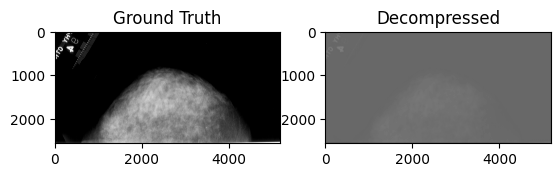

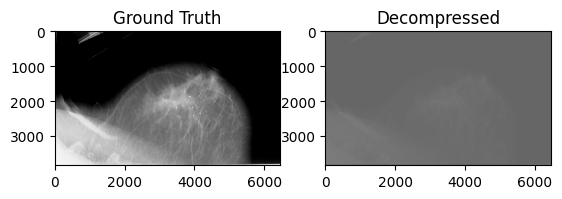

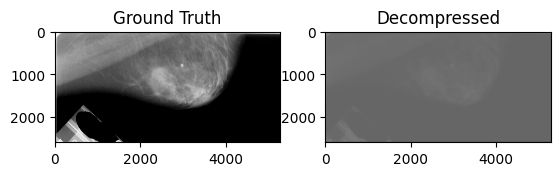

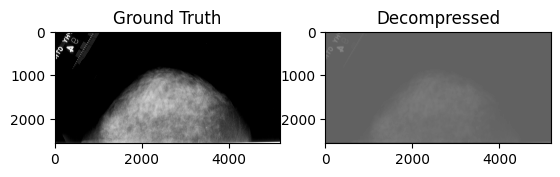

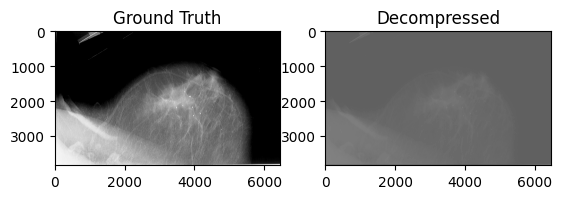

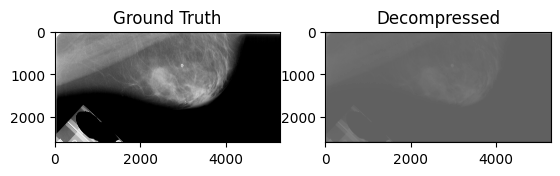

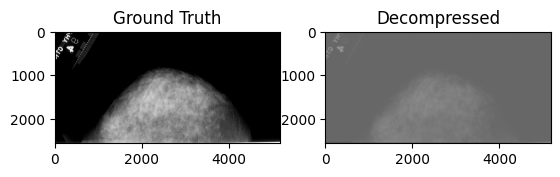

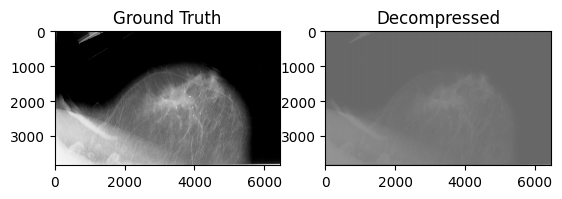

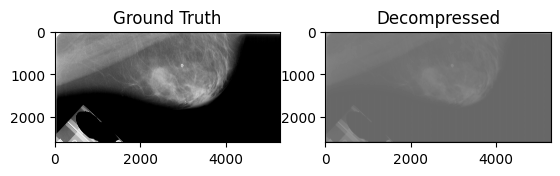

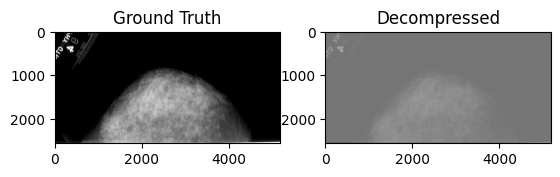

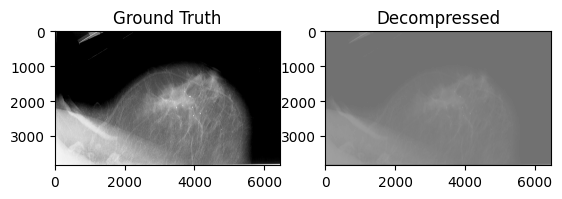

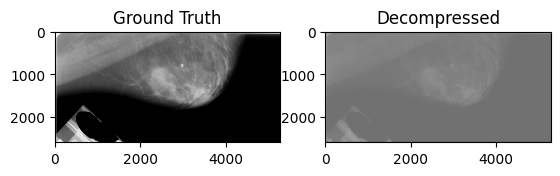

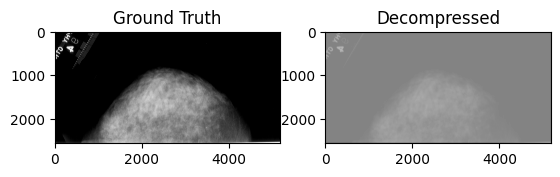

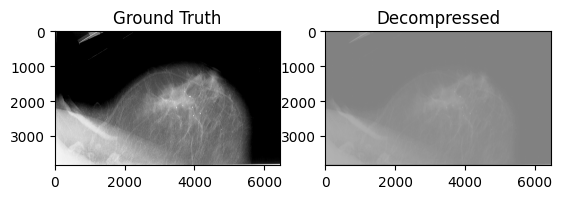

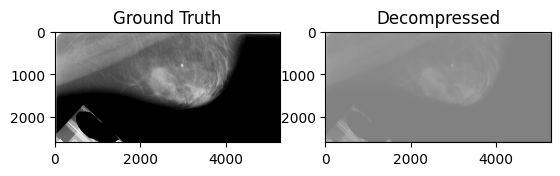

In [24]:
TOTAL_EPOCHS = 5
for epoch in range(TOTAL_EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_model_phase1(config, train_dataloader, model, optimizer, msecrit)

    model.eval()
    with torch.no_grad():
        avg_loss,avg_psnr,avg_ssim = validate_model_phase1(config, test_dataloader, model, msecrit)
print(f'Current Performance, Loss: {avg_loss}, pSNR: {avg_psnr}, SSIM: {avg_ssim}')


Read more about [Training your model](optimization_tutorial.html).




--------------




## Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [25]:
torch.save({'epoch': epoch,
            'model_state': model.state_dict(),
            'optim_state': optimizer.state_dict(),
                }, 'model.pth')